## POOL DOGE_WETH

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
EXPERIMENT_ID = 88

X_NAME = 'DOGE'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [4]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [5]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [6]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [7]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [8]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,False,0.000000e+00,0.000000,0.000000e+00,0,0,False,NaN,NaN
1,2,WETH,DOGE,0.007725,0.0,1019.594013,0.000031,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,17.0,2021-01-18 21:19:04,2021-01-18 21:18:57,0x340d7456b432dd37e467d7a6fe3d6b3843e627d14d20...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x79d774e686d5d3cc1660ea4c88a11702b637852d,2,1.000000e+07,75.000000,7.500000e+08,0,0,False,9.998980e+06,75.007694,7.500005e+08,0,0,False,0.000008,0.000205
2,3,WETH,DOGE,0.041338,0.0,5452.504166,0.000165,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,60.0,2021-01-18 21:29:49,2021-01-18 21:29:35,0x0ea8f1609f74a727484e53da819e12a27159df3fdf6d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x72478dcaaa7fc87718505daf7cb530ae9612e53a,3,9.998980e+06,75.007694,7.500005e+08,0,0,False,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,0.000008,0.001095
3,4,WETH,DOGE,0.025787,0.0,3398.267916,0.000103,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,69.0,2021-01-18 21:32:04,2021-01-18 21:31:54,0xaddc432df998f8884ca9aa2bbe325f8df121cd5c3be6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x212919050e84572e3feb9f7d2d47d061c46fa4da,4,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,9.990130e+06,75.074550,7.500045e+08,0,103959048,False,0.000008,0.000683
4,8,WETH,DOGE,0.300000,0.0,38637.686625,0.001200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,554.0,2021-01-18 23:33:19,2021-01-18 23:33:09,0xa834c8fbd15a81a708243b8f393877846e05b1e871b6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x25770bc4f6b79ec5625c8e61bc92360caae23754,8,5.832849e+07,448.062215,2.613479e+10,0,103959048,False,5.828986e+07,448.361015,2.613490e+10,0,1051014574,False,0.000008,0.001330


In [9]:
swaps0_df.status.value_counts()

SUCCESS                12174
NOT_ENOUGH_RESERVES        1
Name: status, dtype: int64

In [10]:
swaps1_df.status.value_counts()

SUCCESS                             12154
BLOCKED_BY_VOLATILITY_MITIGATION       20
NOT_ENOUGH_RESERVES                     1
Name: status, dtype: int64

In [11]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0016427104722792608


In [12]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                12171
CANT_CONSULT_ORACLE        3
NOT_REACHED                1
Name: mitigator_check_status, dtype: int64

In [13]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.0002464065708418891


In [14]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    16
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    16
Name: status, dtype: int64


**20** transactions have been **blocked by the volatility mitigation mechanism**. In only 0.02% of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle (26% without modification)

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

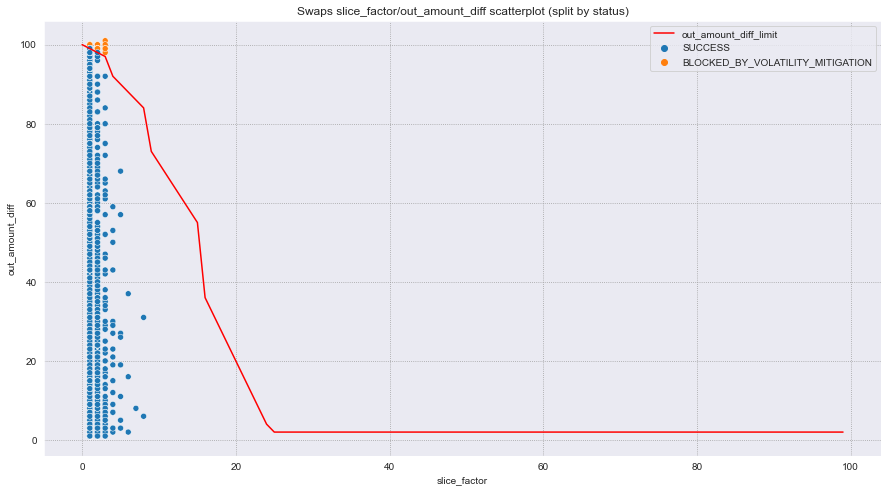

In [15]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

In [20]:
swaps1_df.out_amount_diff.max()

101.0

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**The plot looks similar as in the version without modification in oracle. As the reserves of the pool are very big, all of the swaps have a small slice_factor, despite their relatively big amount_in. In this case, the volatility mitigation mechanism kicks in only when the percentage price difference of the price with the one from oracle is near 100% or greater. There were several sudden price increases in the price of DOGE registered. More, on this, in the following sections**

In [16]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,False,0.000000e+00,0.000000,0.000000e+00,0,0,False,NaN,NaN
1,2,WETH,DOGE,0.007725,0.0,1019.594013,0.000031,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,17.0,2021-01-18 21:19:04,2021-01-18 21:18:57,0x340d7456b432dd37e467d7a6fe3d6b3843e627d14d20...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x79d774e686d5d3cc1660ea4c88a11702b637852d,2,1.000000e+07,75.000000,7.500000e+08,0,0,False,9.998980e+06,75.007694,7.500005e+08,0,0,False,0.000008,0.000205
2,3,WETH,DOGE,0.041338,0.0,5452.504166,0.000165,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,60.0,2021-01-18 21:29:49,2021-01-18 21:29:35,0x0ea8f1609f74a727484e53da819e12a27159df3fdf6d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x72478dcaaa7fc87718505daf7cb530ae9612e53a,3,9.998980e+06,75.007694,7.500005e+08,0,0,False,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,0.000008,0.001095
3,4,WETH,DOGE,0.025787,0.0,3398.267916,0.000103,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,69.0,2021-01-18 21:32:04,2021-01-18 21:31:54,0xaddc432df998f8884ca9aa2bbe325f8df121cd5c3be6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x212919050e84572e3feb9f7d2d47d061c46fa4da,4,9.993528e+06,75.048867,7.500029e+08,0,85982410,False,9.990130e+06,75.074550,7.500045e+08,0,103959048,False,0.000008,0.000683
4,8,WETH,DOGE,0.300000,0.0,38637.686625,0.001200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,554.0,2021-01-18 23:33:19,2021-01-18 23:33:09,0xa834c8fbd15a81a708243b8f393877846e05b1e871b6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x25770bc4f6b79ec5625c8e61bc92360caae23754,8,5.832849e+07,448.062215,2.613479e+10,0,103959048,False,5.828986e+07,448.361015,2.613490e+10,0,1051014574,False,0.000008,0.001330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12170,12212,DOGE,WETH,3100.579942,0.0,0.167324,0.000669,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1779349.0,2021-11-23 19:12:04,2021-11-23 19:12:01,0x7a086f670f8a3ce344a58cc76a01e204816de742e422...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,12212,1.376499e+07,750.502507,1.033066e+10,2077,558373237420,False,1.376809e+07,750.334514,1.033067e+10,2077,558544909487,False,0.000054,-0.000449
12171,12213,DOGE,WETH,38241.829903,0.0,2.057607,0.008230,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1782494.0,2021-11-24 08:18:19,2021-11-24 08:18:12,0xdb47f7f45ec9f7f5a5650ead3a206b2c3d61c0de4bf6...,0xb2bbfd73971279a457514325f209eb63a0341ef2,0xb2bbfd73971279a457514325f209eb63a0341ef2,12213,1.376809e+07,750.334514,1.033067e+10,2077,558544909487,False,1.380633e+07,748.268677,1.033085e+10,2080,559410536370,False,0.000054,-0.005515
12172,12214,DOGE,WETH,100000.000000,0.0,5.327351,0.021309,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1782894.0,2021-11-24 09:58:19,2021-11-24 09:58:15,0xc3a2b979eae3d49d64d85863c9578c987f9732089aa1...,0x1111111254fb6c44bac0bed2854e76f90643097d,0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852,12214,1.380633e+07,748.268677,1.033085e+10,2080,559410536370,False,1.390633e+07,742.920016,1.033129e+10,2080,559521242596,False,0.000053,-0.014288
12173,12215,DOGE,WETH,40517.171810,0.0,2.136746,0.008547,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1786322.0,2021-11-25 00:15:19,2021-11-25 00:15:15,0x5bd

Text(0, 0.5, 'Count')

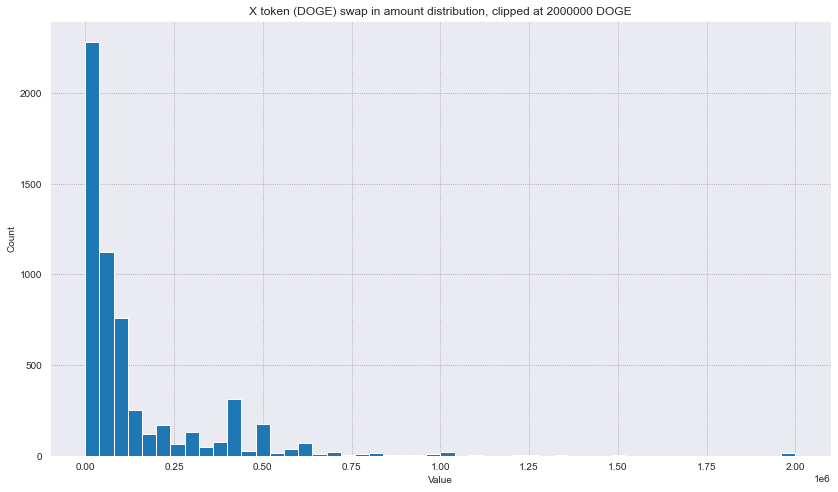

In [17]:
UPPER_LIMIT = 2000000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

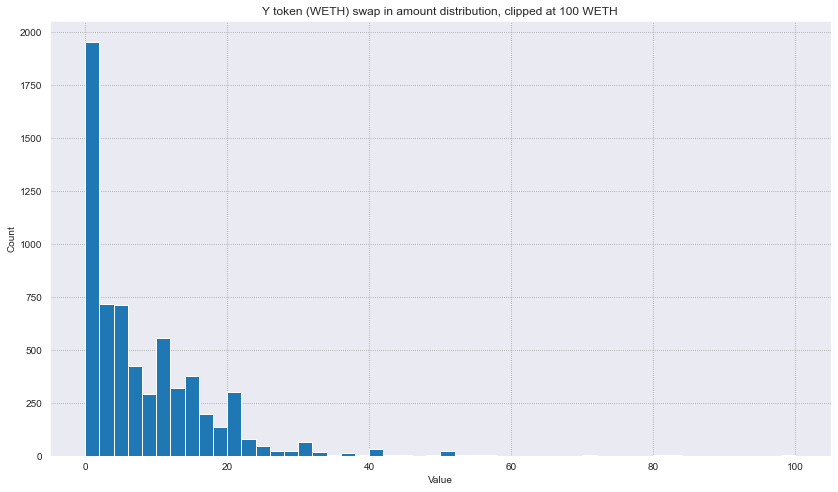

In [18]:
UPPER_LIMIT = 100

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

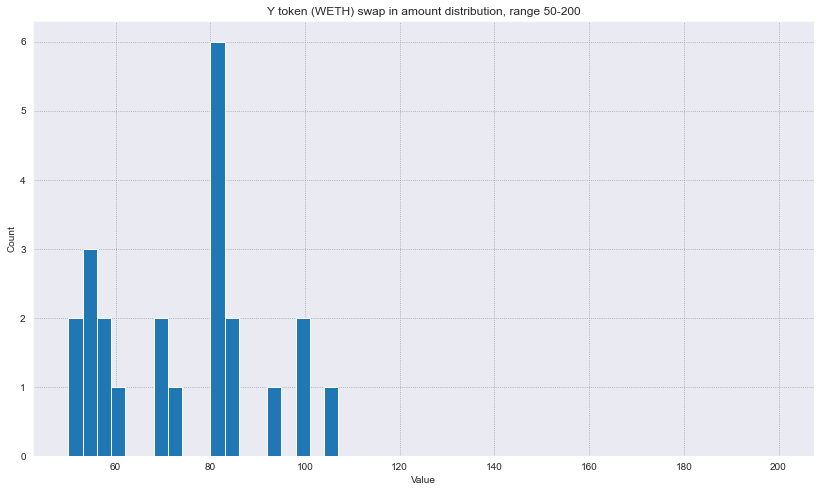

In [19]:
LOWER_LIMIT = 50
UPPER_LIMIT = 200
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

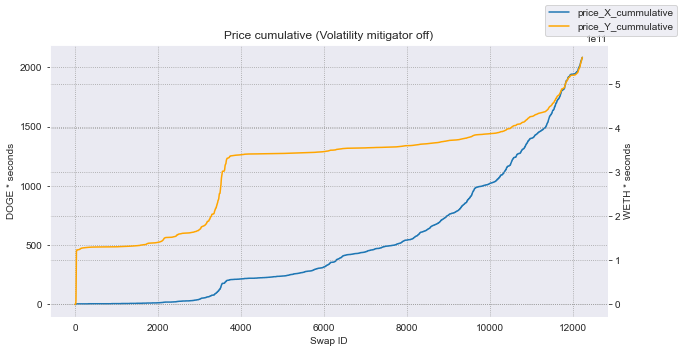

In [20]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

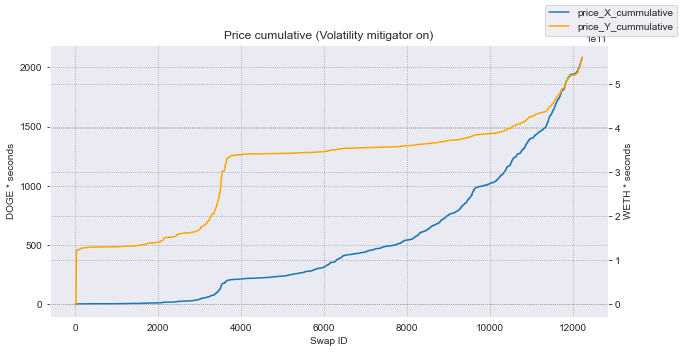

In [21]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

(18655.125, 18658.0)

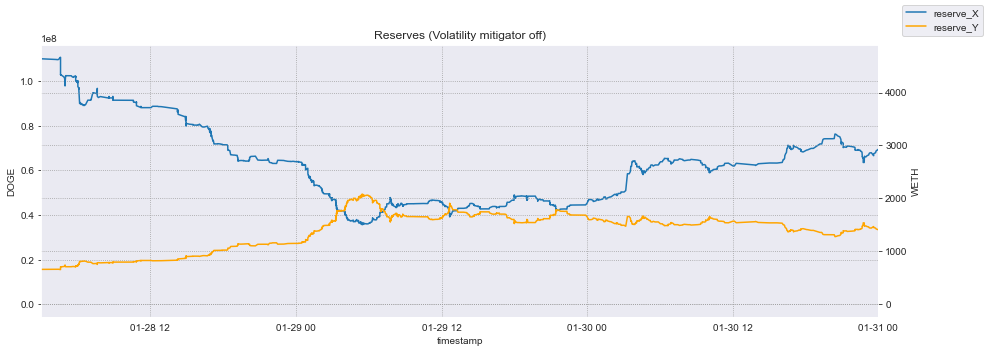

In [23]:
import datetime

fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()
ax.set_xlim(datetime.datetime(2021, 1, 28, 3, 0, 0), datetime.datetime(2021,1,31,0,0,0))


(18655.125, 18658.0)

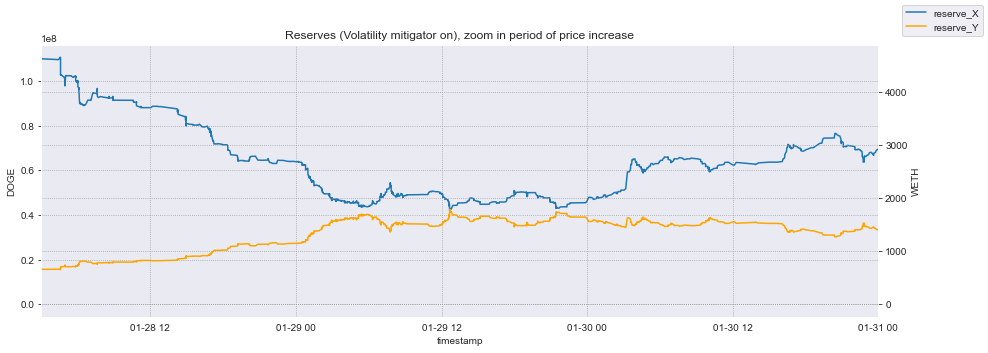

In [24]:
import datetime

fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on), zoom in period of price increase')

fig.legend()

ax.set_xlim(datetime.datetime(2021, 1, 28, 3, 0, 0), datetime.datetime(2021,1,31,0,0,0))


**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

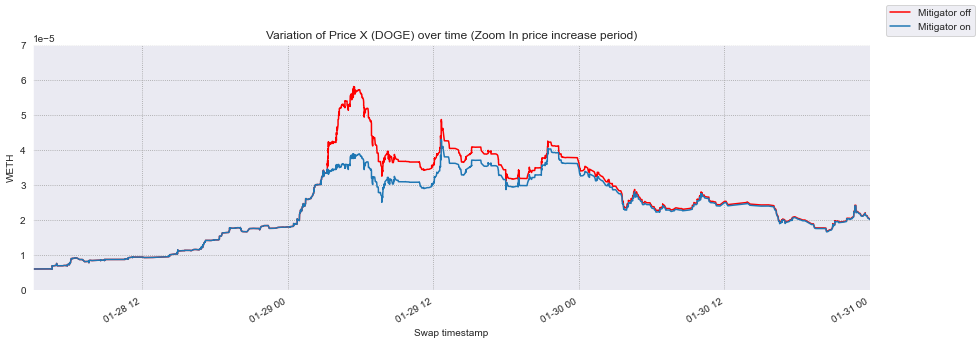

In [25]:
import datetime

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time (Zoom In price increase period)')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

ax.set_xlim(datetime.datetime(2021, 1, 28, 3, 0, 0), datetime.datetime(2021,1,31,0,0,0))
ax.set_ylim(0,0.00007)
plt.gcf().autofmt_xdate()

In [26]:
swaps1_df[swaps1_df.transaction_timestamp >= datetime.datetime(2021, 1, 29, 1, 0, 0)].iloc[:500]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
395,404,WETH,DOGE,1.000000e+01,0.0,4.507481e+05,0.040000,CHECKED,9.170009e+05,68.0,1.0,1.0,SUCCESS,58507.0,2021-01-29 01:01:34,2021-01-29 01:01:29,0xa2497b36d497a256ce93374a7f1f2260b9292426bfaa...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x205b7b1daee38c4744c6f0b782e27bca286c23db,404,5.816014e+07,1267.499555,7.371795e+10,6,130117433288,True,5.770939e+07,1277.459555,7.372141e+10,6,130121563004,True,0.000022,1.573002e-02
396,405,WETH,DOGE,1.662616e-01,0.0,7.434821e+03,0.000665,CHECKED,1.524000e+04,68.0,1.0,1.0,SUCCESS,58511.0,2021-01-29 01:02:34,2021-01-29 01:02:22,0x1f213e2ed0912aeb3a01a29933b6941cd7e8c7fce0bb...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x012bb8c78f8436a3bb9a86e26727716edc685f7b,405,5.770939e+07,1277.459555,7.372141e+10,6,130121563004,True,5.770196e+07,1277.625152,7.372147e+10,6,130124273511,True,0.000022,2.584950e-04
397,406,DOGE,WETH,4.078883e+04,0.0,8.934814e-01,0.003574,CHECKED,4.975073e-01,56.0,1.0,1.0,SUCCESS,58513.0,2021-01-29 01:03:04,2021-01-29 01:02:54,0xedc8076bb72ffff270e637140eb5fc5723565162db60...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,406,5.770196e+07,1277.625152,7.372147e+10,6,130124273511,True,5.774274e+07,1276.728096,7.372178e+10,6,130125628414,True,0.000022,-1.408020e-03
398,407,WETH,DOGE,1.703676e+01,0.0,7.528724e+05,0.068147,CHECKED,1.561160e+06,69.0,2.0,2.0,SUCCESS,58514.0,2021-01-29 01:03:19,2021-01-29 01:03:11,0x9e38e2e4b7fb4c299b48086344fbadd41e3c1a8ca5c2...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x634a35d24600b3dbab4d6f1d8d0de7cbc484eccc,407,5.774274e+07,1276.728096,7.372178e+10,6,130125628414,True,5.698987e+07,1293.696706,7.372761e+10,6,130126306821,True,0.000023,2.667691e-02
399,408,WETH,DOGE,5.102185e+00,0.0,2.216482e+05,0.020409,CHECKED,4.673434e+05,71.0,1.0,1.0,SUCCESS,58518.0,2021-01-29 01:04:19,2021-01-29 01:04:12,0x954ed65d332d3479d804b62a85bb918508557da8ab47...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9f98f57af2eaf193a1b496b5224a0254a8db9d65,408,5.698987e+07,1293.696706,7.372761e+10,6,130126306821,True,5.676822e+07,1298.778482,7.372935e+10,6,130128949939,True,0.000023,7.847883e-03
400,409,WETH,DOGE,5.000000e+00,0.0,2.155378e+05,0.020000,CHECKED,4.577441e+05,71.0,1.0,1.0,SUCCESS,58523.0,2021-01-29 01:05:34,2021-01-29 01:05:32,0x51500ca1769fc0f0e6600bf37e171203260a0bcb5829...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x63aea877b5d5fa234a1532f1b26a4f6d9051866e,409,5.676822e+07,1298.778482,7.372935e+10,6,130128949939,True,5.655269e+07,1303.758482,7.373104e+10,6,130132228109,True,0.000023,7.660259e-03
401,410,WETH,DOGE,5.000000e-01,0.0,2.146330e+04,0.002000,CHECKED,4.577441e+04,72.0,1.0,1.0,SUCCESS,58523.0,2021-01-29 01:05:34,2021-01-29 01:05:32,0x4a52c0e31541e05520e36f704542a22581baa7720632...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xd5bdab6e0d85ba96eda4131da137aa45bf030e38,410,5.655269e+07,1303.758482,7.373104e+10,6,130132228109,True,5.653122e+07,1304.256482,7.373121e+10,6,130132228109,True,0.000023,7.617892e-04
402,411,DOGE,WETH,1.371007e+05,0.0,3.123977e+00,0.012496,CHECKED,1.677503e+00,60.0,1.0,1.0,SUCCESS,58531.0,2021-01-29 01:07:34,2021-01-29 01:07:29,0x663d9dc379ae4581a642d9f02aa5fe4e4fbe24a18663...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x0d0542840f0a831ab16cc71932001617d6d88588,411,5.653122e+07,1304.256482,7.373121e+10,6,130132228109,True,5.666832e+07,1301.120009,7.373229e+10,6,130137429345,True,0.000023,-4.818332e-03
403,412,DOGE,WETH,4.523581e+05,0.0,1.020178e+01,0.040807,CHECKED,5.536791e+00,59.0,1.0,1.0,SUCCESS,

In [30]:
swaps1_df[swaps1_df.status != 'SUCCESS']

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000e+00,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,True,0.000000e+00,0.000000,0.000000e+00,0,0,True,NaN,NaN
516,525,WETH,DOGE,2.448205,0.0,7.080741e+04,NaN,CHECKED,2.130385e+05,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,58972.0,2021-01-29 02:57:49,2021-01-29 02:57:37,0x4f247df9884ba45eb070c7a51f5734f85da025e9a156...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x5c19769d43d97629f6d6cbe93a4c4cd516434c26,525,4.649579e+07,1589.117549,7.388728e+10,6,130376375325,True,4.649579e+07,1589.117549,7.388728e+10,6,130378569741,True,0.000034,0.0
545,554,WETH,DOGE,35.260201,0.0,1.017994e+06,NaN,CHECKED,3.040602e+06,99.0,3.0,3.0,BLOCKED_BY_VOLATILITY_MITIGATION,59048.0,2021-01-29 03:16:49,2021-01-29 03:16:38,0xaf76eaca682fe6e0ee9ac270cbc8ec6a86f31d92b2d4...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc5d496bccf6780d2fc61ec31df37a887387bb114,554,4.694682e+07,1574.926252,7.393778e+10,6,130412726377,True,4.694682e+07,1574.926252,7.393778e+10,6,130412726377,True,0.000034,0.0
551,560,WETH,DOGE,6.360000,0.0,1.816608e+05,NaN,CHECKED,5.480491e+05,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,59054.0,2021-01-29 03:18:19,2021-01-29 03:18:15,0xbcf1ba476b377d6840d26bfc5690f3320c28f9ed5735...,0x6f21854a903f396efdd36c2d145af973e2efe004,0x6f21854a903f396efdd36c2d145af973e2efe004,560,4.628226e+07,1597.856031,7.395239e+10,6,130414909614,True,4.628226e+07,1597.856031,7.395239e+10,6,130415344092,True,0.000035,0.0
554,563,WETH,DOGE,37.281147,0.0,1.072248e+06,NaN,CHECKED,3.212179e+06,99.0,3.0,3.0,BLOCKED_BY_VOLATILITY_MITIGATION,59055.0,2021-01-29 03:18:34,2021-01-29 03:18:24,0xeddda7eafe2cecee06617894f30784af3b3bfc098bb6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x1611c227725c5e420ef058275ae772b41775e261,563,4.689230e+07,1577.192610,7.395819e+10,6,130415781840,True,4.689230e+07,1577.192610,7.395819e+10,6,130415781840,True,0.000034,0.0
559,568,WETH,DOGE,12.000000,0.0,3.442424e+05,NaN,CHECKED,1.033443e+06,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,59059.0,2021-01-29 03:19:34,2021-01-29 03:19:32,0xa655b6d996aee66c4372a808262ef4df42d362e87951...,0xc40037dbe19d0e208904a5cfbd8edaa34a87958a,0xc40037dbe19d0e208904a5cfbd8edaa34a87958a,568,4.646773e+07,1591.747430,7.396488e+10,6,130417570824,True,4.646773e+07,1591.747430,7.396488e+10,6,130417570824,True,0.000034,0.0
566,575,WETH,DOGE,5.860000,0.0,1.678336e+05,NaN,CHECKED,5.043045e+05,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,59065.0,2021-01-29 03:21:04,2021-01-29 03:20:59,0xd1bccdc74567f115f730ef82a83505af0a484a75d7bb...,0x6f21854a903f396efdd36c2d145af973e2efe004,0x6f21854a903f396efdd36c2d145af973e2efe004,575,4.634493e+07,1596.175117,7.397462e+10,6,130419780916,True,4.634493e+07,1596.175117,7.397462e+10,6,130420216440,True,0.000034,0.0
567,576,WETH,DOGE,39.763384,0.0,1.115474e+06,NaN,CHECKED,3.421989e+06,101.0,3.0,3.0,BLOCKED_BY_VOLATILITY_MITIGATION,59065.0,2021-01-29 03:21:04,2021-01-29 03:20:59,0x698c2ef62c51453551aae7c1cf3e386c59589b17adbe...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc5d496bccf6780d2fc61ec31df37a887387bb114,576,4.634493e+07,1596.175117,7.397462e+10,6,130420216440,True,4.634493e+07,1596.175117,7.397462e+10,6,130420216440,True,0.000034,0.0
571,580,WETH,DOGE,16.580838,0.0,4.766289e+05,NaN,CHECKED,1.426422e+06,99.0,2.0,2.0,BLOCKED_BY_VOLA

In [25]:
#datetime.datetime(2021, 1, 28, 3, 0, 0)

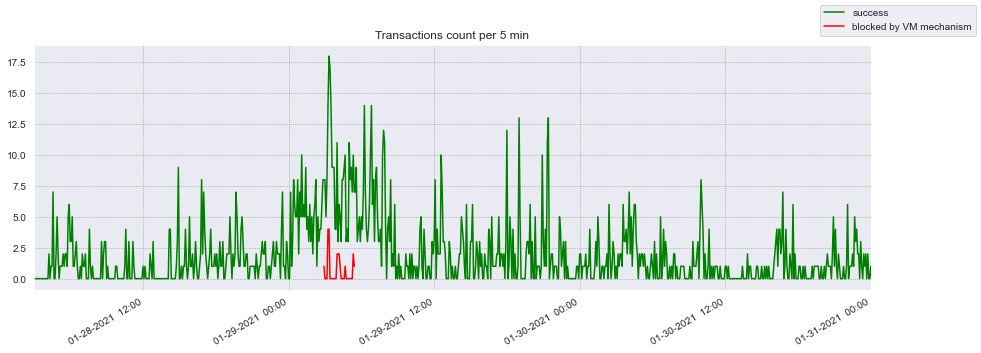

In [26]:
import matplotlib.dates as mdates

sim1_indexed_blocked_df = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION']
sim1_indexed_blocked_df.index = sim1_indexed_blocked_df.transaction_timestamp
resampled_blocked = sim1_indexed_blocked_df.resample('5min').size()

sim1_indexed_success_df = swaps1_df[swaps1_df.status == 'SUCCESS']
sim1_indexed_success_df.index = sim1_indexed_success_df.transaction_timestamp
resampled_success = sim1_indexed_success_df.resample('5min').size()

#resampled_success = resampled_success[(resampled_success.index >= resampled_blocked.index.min()) & (3resampled_success.index <= resampled_blocked.index.max())]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled_success.index, y=resampled_success, linestyle='solid', marker=None, color='green', label='success')
ax.plot_date(x=resampled_blocked.index, y=resampled_blocked, linestyle='solid', marker=None, color='red', label='blocked by VM mechanism')

ax.set_xlim(datetime.datetime(2021, 1, 28, 3, 0, 0), datetime.datetime(2021,1,31,0,0,0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y  %H:%M'))

fig.legend()
ax.set_title('Transactions count per 5 min')
plt.gcf().autofmt_xdate()

In [79]:
swaps1_df[swaps1_df.status != 'SUCCESS']

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,DOGE,1.000000,0.0,0.000000e+00,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2021-01-18 21:14:49,2021-01-18 21:14:49,0xebb57fcd4f7c7c8c155d6e5a80f3212c7f2d80640bb3...,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0xb89fa54d5d7bcb78e121f9fa85cb47242355c68e,0,0.000000e+00,0.000000,0.000000e+00,0,0,True,0.000000e+00,0.000000,0.000000e+00,0,0,True,NaN,NaN
516,525,WETH,DOGE,2.448205,0.0,7.080741e+04,NaN,CHECKED,2.130385e+05,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,58972.0,2021-01-29 02:57:49,2021-01-29 02:57:37,0x4f247df9884ba45eb070c7a51f5734f85da025e9a156...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x5c19769d43d97629f6d6cbe93a4c4cd516434c26,525,4.649579e+07,1589.117549,7.388728e+10,6,130376375325,True,4.649579e+07,1589.117549,7.388728e+10,6,130378569741,True,0.000034,0.0
545,554,WETH,DOGE,35.260201,0.0,1.017994e+06,NaN,CHECKED,3.040602e+06,99.0,3.0,3.0,BLOCKED_BY_VOLATILITY_MITIGATION,59048.0,2021-01-29 03:16:49,2021-01-29 03:16:38,0xaf76eaca682fe6e0ee9ac270cbc8ec6a86f31d92b2d4...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc5d496bccf6780d2fc61ec31df37a887387bb114,554,4.694682e+07,1574.926252,7.393778e+10,6,130412726377,True,4.694682e+07,1574.926252,7.393778e+10,6,130412726377,True,0.000034,0.0
551,560,WETH,DOGE,6.360000,0.0,1.816608e+05,NaN,CHECKED,5.480491e+05,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,59054.0,2021-01-29 03:18:19,2021-01-29 03:18:15,0xbcf1ba476b377d6840d26bfc5690f3320c28f9ed5735...,0x6f21854a903f396efdd36c2d145af973e2efe004,0x6f21854a903f396efdd36c2d145af973e2efe004,560,4.628226e+07,1597.856031,7.395239e+10,6,130414909614,True,4.628226e+07,1597.856031,7.395239e+10,6,130415344092,True,0.000035,0.0
554,563,WETH,DOGE,37.281147,0.0,1.072248e+06,NaN,CHECKED,3.212179e+06,99.0,3.0,3.0,BLOCKED_BY_VOLATILITY_MITIGATION,59055.0,2021-01-29 03:18:34,2021-01-29 03:18:24,0xeddda7eafe2cecee06617894f30784af3b3bfc098bb6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x1611c227725c5e420ef058275ae772b41775e261,563,4.689230e+07,1577.192610,7.395819e+10,6,130415781840,True,4.689230e+07,1577.192610,7.395819e+10,6,130415781840,True,0.000034,0.0
559,568,WETH,DOGE,12.000000,0.0,3.442424e+05,NaN,CHECKED,1.033443e+06,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,59059.0,2021-01-29 03:19:34,2021-01-29 03:19:32,0xa655b6d996aee66c4372a808262ef4df42d362e87951...,0xc40037dbe19d0e208904a5cfbd8edaa34a87958a,0xc40037dbe19d0e208904a5cfbd8edaa34a87958a,568,4.646773e+07,1591.747430,7.396488e+10,6,130417570824,True,4.646773e+07,1591.747430,7.396488e+10,6,130417570824,True,0.000034,0.0
566,575,WETH,DOGE,5.860000,0.0,1.678336e+05,NaN,CHECKED,5.043045e+05,100.0,1.0,1.0,BLOCKED_BY_VOLATILITY_MITIGATION,59065.0,2021-01-29 03:21:04,2021-01-29 03:20:59,0xd1bccdc74567f115f730ef82a83505af0a484a75d7bb...,0x6f21854a903f396efdd36c2d145af973e2efe004,0x6f21854a903f396efdd36c2d145af973e2efe004,575,4.634493e+07,1596.175117,7.397462e+10,6,130419780916,True,4.634493e+07,1596.175117,7.397462e+10,6,130420216440,True,0.000034,0.0
567,576,WETH,DOGE,39.763384,0.0,1.115474e+06,NaN,CHECKED,3.421989e+06,101.0,3.0,3.0,BLOCKED_BY_VOLATILITY_MITIGATION,59065.0,2021-01-29 03:21:04,2021-01-29 03:20:59,0x698c2ef62c51453551aae7c1cf3e386c59589b17adbe...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc5d496bccf6780d2fc61ec31df37a887387bb114,576,4.634493e+07,1596.175117,7.397462e+10,6,130420216440,True,4.634493e+07,1596.175117,7.397462e+10,6,130420216440,True,0.000034,0.0
571,580,WETH,DOGE,16.580838,0.0,4.766289e+05,NaN,CHECKED,1.426422e+06,99.0,2.0,2.0,BLOCKED_BY_VOLA

**The variation of price is the same as in the initial version**

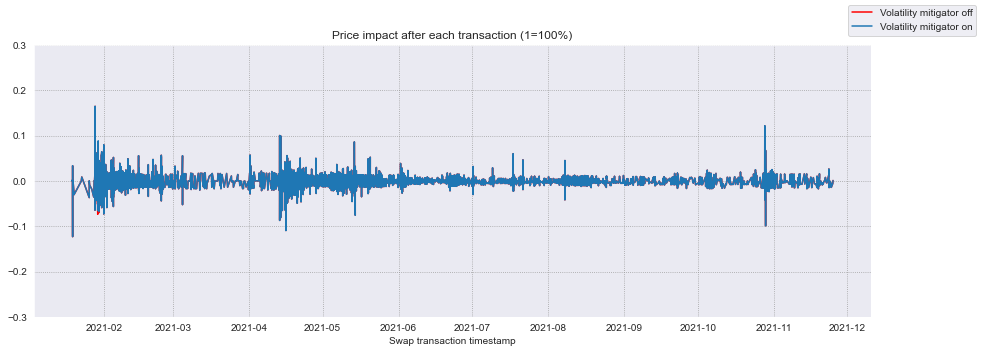

In [72]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

In [97]:
swaps1_df[swaps1_df.price_diff > 0.1].tail().iloc[-2].at['txd']

'0x7c0446eefa9b1812cd5ebab6e6703f96b69db875717636848b32e7bb16949c35'

In [74]:
swaps1_df.iloc[615:623]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
615,624,WETH,DOGE,0.440447,0.0,12824.239390,0.001762,CHECKED,37655.399369,98.0,1.0,1.0,SUCCESS,59121.0,2021-01-29 03:35:04,2021-01-29 03:35:04,0xbdcb857bdb0177aad33a32caa7b5219ca54f442a9504...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x0398219ff15f6fb810cd10c214d39331e2c17df6,624,4.665970e+07,1586.059447,7.400505e+10,6,130445059621,True,4.664687e+07,1586.498132,7.400517e+10,6,130445059621,True,0.000034,0.000552
616,625,WETH,DOGE,0.100000,0.0,2910.657102,0.000400,CHECKED,8549.365625,98.0,1.0,1.0,SUCCESS,59121.0,2021-01-29 03:35:04,2021-01-29 03:35:04,0xc8cc0bea5ba85ec60ed305a59ceba1fe9ca6054c8c30...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x6125738b8765809ff865565b1354822fc5e0d8b6,625,4.664687e+07,1586.498132,7.400517e+10,6,130445059621,True,4.664396e+07,1586.597732,7.400520e+10,6,130445059621,True,0.000034,0.000125
617,626,WETH,DOGE,0.200000,0.0,5820.222430,0.000800,CHECKED,17096.727144,98.0,1.0,1.0,SUCCESS,59122.0,2021-01-29 03:35:19,2021-01-29 03:35:06,0x94365242d69d01a091c1fcfdb77014a45db92f5424c1...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x718def6383435d6581159b67c87ebb97b4a8f8a2,626,4.664396e+07,1586.597732,7.400520e+10,6,130445059621,True,4.663814e+07,1586.796932,7.400526e+10,6,130445500602,True,0.000034,0.000250
618,627,WETH,DOGE,0.622234,0.0,18098.394279,0.002489,CHECKED,53184.567437,98.0,1.0,1.0,SUCCESS,59123.0,2021-01-29 03:35:34,2021-01-29 03:35:24,0x7deb8da9a47cf27299eeecc56c1655932c87358f0a31...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x5b3b1de2e1cf13580c2cc0ec265091adc36bcbd0,627,4.663814e+07,1586.796932,7.400526e+10,6,130445500602,True,4.662004e+07,1587.416677,7.400543e+10,6,130445941472,True,0.000034,0.000779
619,628,WETH,DOGE,0.469280,0.0,13640.228061,0.001877,CHECKED,40106.335388,98.0,1.0,1.0,SUCCESS,59124.0,2021-01-29 03:35:49,2021-01-29 03:35:47,0x4374e773cb760f8848477d46837aade1cceca124b3d1...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x650786a0b235e9588e628f3cea57bae429c68ff9,628,4.662004e+07,1587.416677,7.400543e+10,6,130445941472,True,4.660640e+07,1587.884080,7.400556e+10,6,130446382000,True,0.000034,0.000587
620,629,WETH,DOGE,0.102804,0.0,2987.072598,0.000411,CHECKED,8778.831029,98.0,1.0,1.0,SUCCESS,59131.0,2021-01-29 03:37:34,2021-01-29 03:37:20,0xdc1d555ec5caa2bbac7d919abcf46d06bd49cbd9ff00...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x6e835a33b86136f42d568757538d9d36197b0bab,629,4.660640e+07,1587.884080,7.400556e+10,6,130446382000,True,4.660341e+07,1587.986473,7.400559e+10,6,130449463882,True,0.000034,0.000129
621,630,WETH,DOGE,5.000000,0.0,144818.644338,0.020000,CHECKED,426668.177796,98.0,1.0,1.0,SUCCESS,59137.0,2021-01-29 03:39:04,2021-01-29 03:38:52,0x4ab9edb4ebf9f9746523fde2c508df95bd28b4984f10...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x1a9a6baf898fb0c6265f1a3d33660db0a8bc9909,630,4.660341e+07,1587.986473,7.400559e+10,6,130449463882,True,4.645860e+07,1592.966473,7.400699e+10,6,130452105156,True,0.000034,0.006263
622,631,WETH,DOGE,0.010000,0.0,288.730018,0.000040,CHECKED,852.936364,98.0,1.0,1.0,SUCCESS,59141.0,2021-01-29 03:40:04,2021-01-29 03:39:53,0x368d97e93fe4d1dae74e8679fdf5e774cc10c667ea14...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x654003b19f48bca3cf83b570982017aa364be312,631,4.645860e+07,1592.966473,7.400699e+10,6,130452105156,True,4.645831e+07,1592.976433,7.400699e+10,6,130453855046,True,0.000034,0.000012


**The price impact after each transaction doesn't exceed 0.25 and is the same as initially before the modification in the DSW oracle**